In [26]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from typing import TypedDict, Annotated,Literal
from langchain_core.messages import HumanMessage, SystemMessage
from pydantic import BaseModel, Field
import operator

In [25]:
load_dotenv()

True

In [27]:
generator_llm = ChatOpenAI(model="gpt-4o")
evaluator_llm = ChatOpenAI(model="gpt-4o-mini")
optimizer_llm = ChatOpenAI(model="gpt-4o")

In [28]:
class TweetEvalution(BaseModel):
    evaluation:Literal["approved","needs_improvement"] = Field(..., description="The evaluation of the tweet")
    feedback:str = Field(..., description="Feedback on how to improve the tweet if needed")
    # score:int= Field(..., ge=0,le=10, description="A score from 1 to 10 indicating the quality of the tweet")

In [29]:
structured_evaluator_llm=evaluator_llm.with_structured_output(TweetEvalution)

In [30]:
# state
class TweetState(TypedDict):
    topic:str
    tweet:str
    evaluation: Literal["approved","needs_improvement"] 
    feedback:str
    iteration:int
    max_iterations:int

In [31]:
def generate_tweet(state:TweetState) :
    prompt = [
        SystemMessage(content="You are a creative social media content creator."),
        HumanMessage(content=f"""Create a tweet about the following topic: "{state['topic']}".
                     Rules: 
                     - Keep it under 280 characters.
                     - Make it engaging and relevant to current trends.
                     - Use appropriate hashtags.
                     -do not use question-answer format.
                     -this is version {state['iteration']+1}""")
    ]
    response = generator_llm.invoke(prompt)
    return {"tweet": response.content}
    

In [32]:
def evaluate_tweet(state: TweetState):
    message = [
        SystemMessage(content="You are a meticulous social media content evaluator."),
        HumanMessage(content=f"""Evaluate the following tweet for its effectiveness and engagement potential:
                     Tweet: "{state['tweet']}"
                     Rules:
                     - Provide a clear evaluation: "approved" or "needs_improvement".
                     - If "needs_improvement", provide specific feedback on what can be improved.
                     - Consider factors like clarity, engagement, relevance, and adherence to Twitter norms.
                     - Automatically reject if tweet is in question-answer format.
                     - Reject if tweet exceeds 280 characters.
                     
                     ### Respond only in structured format as:
                     evaluation: approved or needs_improvement
                     feedback: specific feedback or "N/A" if approved
                     """)
    ]
    
    response = structured_evaluator_llm.invoke(message)
    
     # handle both dict-like and object-like responses robustly
    if isinstance(response, dict):
        eval_val = response.get("evaluation")
        fb = response.get("feedback")
    else:
        eval_val = getattr(response, "evaluation", None)
        fb = getattr(response, "feedback", None)

    return {"evaluation": eval_val, "feedback": fb}


In [33]:
def optimize_tweet(state:TweetState) :
    prompt = [
        SystemMessage(content="You are a skilled social media content optimizer."),
        HumanMessage(content=f"""Optimize the following tweet based on the provided feedback:
                     Original Tweet: "{state['tweet']}"
                     Feedback: "{state['feedback']}"
                     Rules:
                     - Address all points mentioned in the feedback.
                     - Maintain the original topic and intent of the tweet.
                     - Ensure the tweet is engaging and adheres to Twitter norms.
                     - Keep it under 280 characters.
                     - Use appropriate hashtags.
                     -do not use question-answer format.
                     """)
    ]
    response = optimizer_llm.invoke(prompt).content
    iteration=state['iteration']+1
    return {"tweet": response,"iteration":iteration}

In [34]:
def route_evaluation(state: TweetState):
    # use .get to avoid KeyError if key is missing
    if state.get("evaluation") == "approved" or state["iteration"] >= state["max_iterations"]:
        return "approved"
    return "needs_improvement"

In [35]:
graph=StateGraph(TweetState)

In [36]:
# nodes
graph.add_node("generate_tweet",generate_tweet)
graph.add_node("evaluate_tweet",evaluate_tweet)
graph.add_node("optimize_tweet",optimize_tweet)

In [ ]:
# edges
graph.add_edge(START, "generate_tweet")
graph.add_edge("generate_tweet", "evaluate_tweet")

graph.add_conditional_edges("evaluate_tweet", route_evaluation, {"approved": END, "needs_improvement": "optimize_tweet"})
graph.add_edge("optimize_tweet", "evaluate_tweet")

workflow = graph.compile()

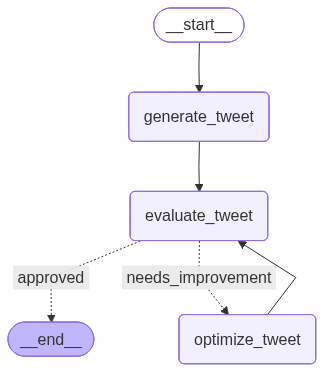

In [19]:
workflow

In [22]:
inital_state={
    "topic":"indian criket",
    "iteration":2,
    "max_iterations":5
}
workflow.invoke(inital_state)

AttributeError: 'TweetEvalution' object has no attribute 'evalution'